In [52]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [54]:
IMG_SIZE = 224

mannual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
mannual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [55]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [56]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [57]:
BATCH_SIZE = 32
train_loader, test_loader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=mannual_transforms,
    batch_size=BATCH_SIZE
)

train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa3a1b50700>,
 ['pizza', 'steak', 'sushi'])

In [58]:
image_batch, label_batch = next(iter(train_loader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

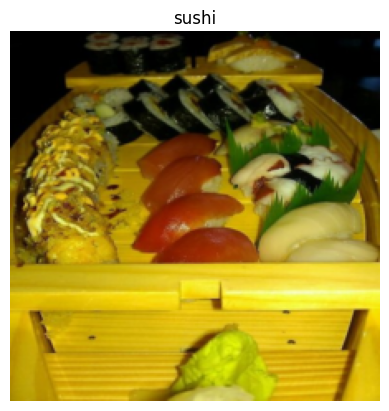

In [59]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [60]:
height = 224
width = 224
color_channels = 3
patch_size = 16
num_of_patches = int((height * width) / (patch_size ** 2))
num_of_patches

196

In [61]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (num_of_patches, color_channels * patch_size ** 2)
print(f"Embedding layer input shape: {embedding_layer_input_shape}")
print(f"Embedding layer output shape: {embedding_layer_output_shape}")

Embedding layer input shape: (224, 224, 3)
Embedding layer output shape: (196, 768)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

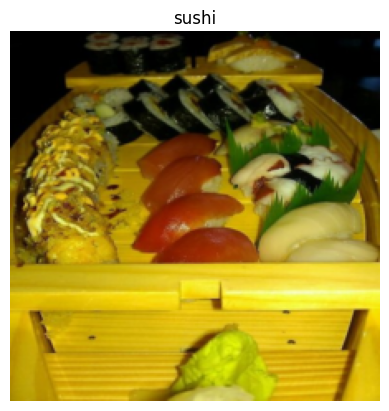

In [62]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

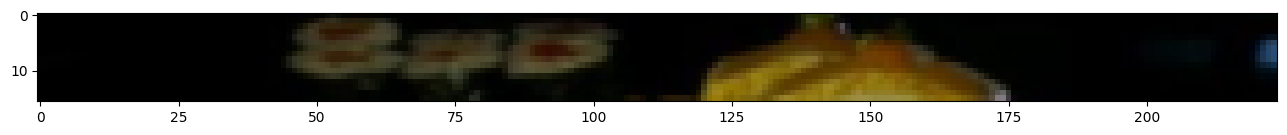

In [63]:
image_permuted = image.permute(1, 2, 0)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

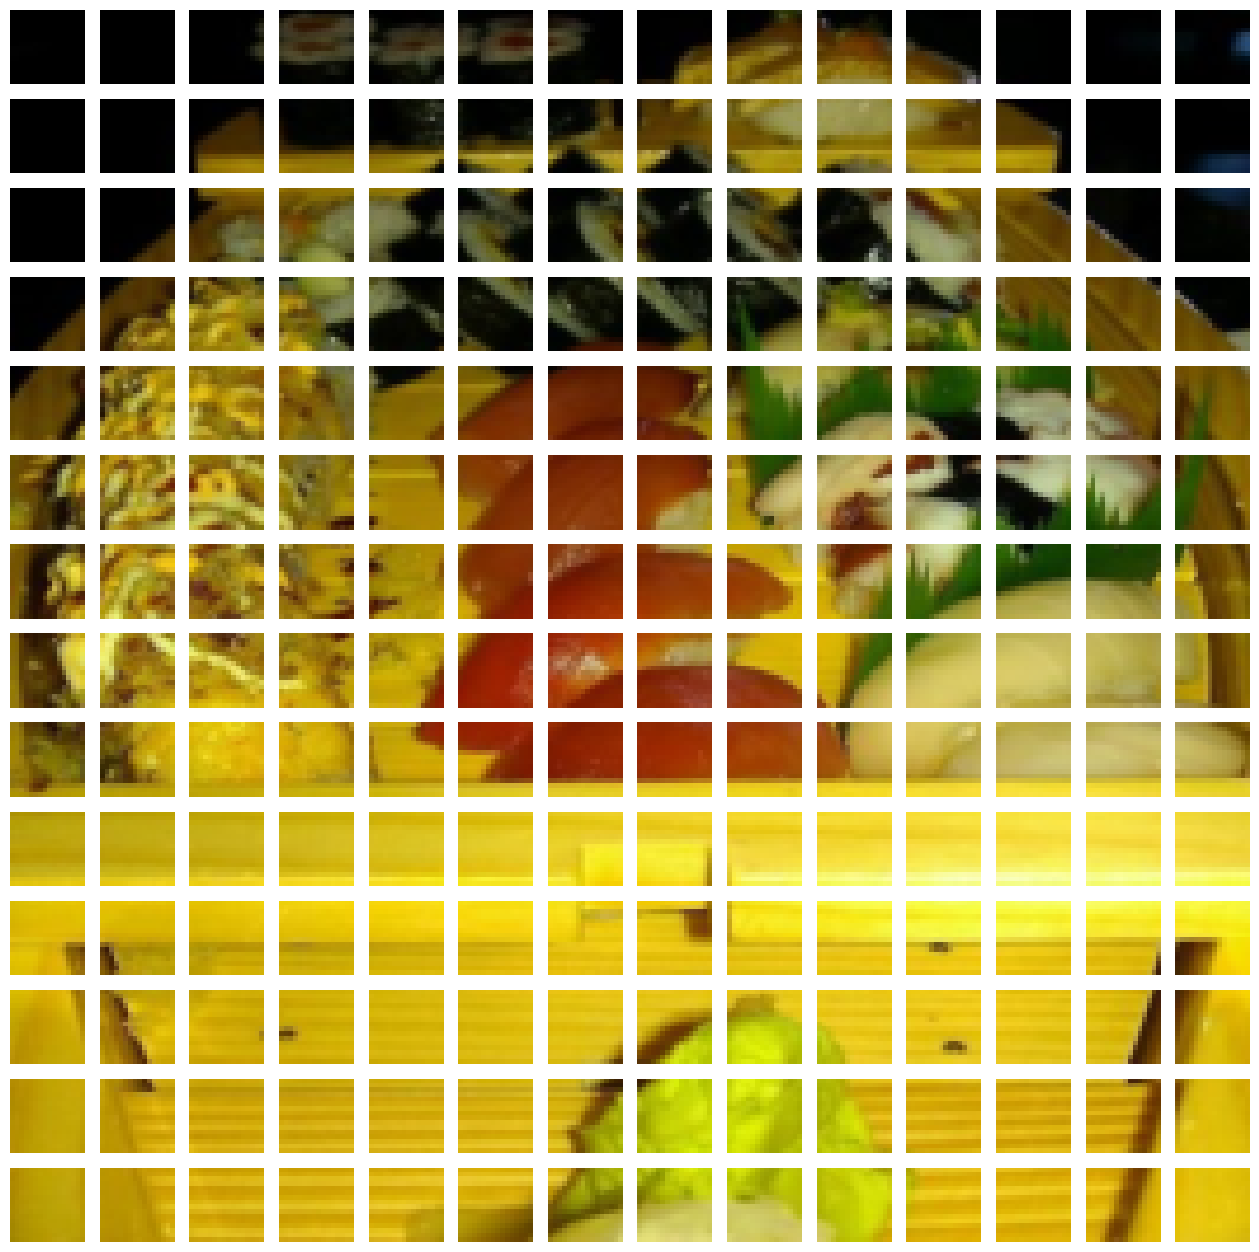

In [64]:
fig, axs = plt.subplots(
    nrows=IMG_SIZE // patch_size,
    ncols=IMG_SIZE // patch_size,
    figsize=(patch_size, patch_size),
    sharex=True, sharey=True
)

for i, patch_height in enumerate(range(0, IMG_SIZE, patch_size)):
    for j, patch_width in enumerate(range(0, IMG_SIZE, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size, patch_width:patch_width + patch_size, :])
        axs[i, j].axis(False)

In [65]:
conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0,
)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

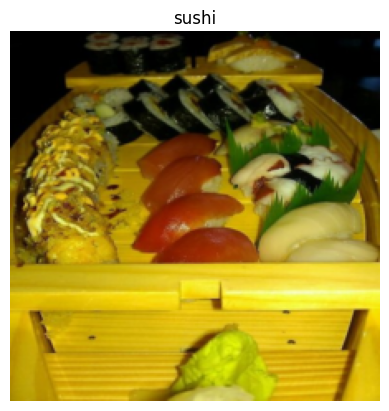

In [66]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [67]:
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])


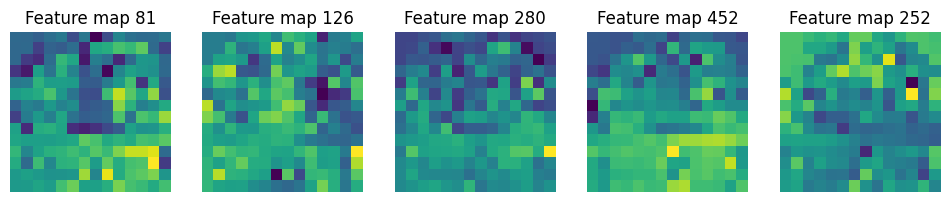

In [68]:
import random
random_indexes = random.sample(range(0, 768), k=5)
fig, axs = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12, 12)
)
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :].squeeze()
    print(image_conv_feature_map.shape)
    axs[i].imshow(image_conv_feature_map.detach().cpu().numpy())
    axs[i].axis(False)
    axs[i].set_title(f"Feature map {idx}")

In [69]:
flatten = nn.Flatten(
    start_dim = 2,
    end_dim = 3
)
image_out_of_conv_flattened = flatten(image_out_of_conv)
image_out_of_conv_flattened.shape

torch.Size([1, 768, 196])

In [70]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
image_out_of_conv_flattened_reshaped.shape

torch.Size([1, 196, 768])

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

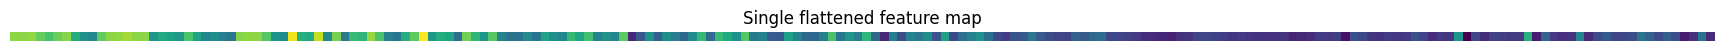

In [71]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().cpu().numpy())
plt.title("Single flattened feature map")
plt.axis(False)

In [72]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768) -> None:
        super().__init__()
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Image resolution {image_resolution} must be divisible by patch size {patch_size}."
        x = self.patcher(x)
        x = self.flatten(x)
        return x.permute(0, 2, 1)

In [73]:
set_seeds(42)
patchify = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)
patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [74]:
random_input_image = (1, 3, 224, 224)
summary(
    PatchEmbedding(),
    input_size=random_input_image,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [75]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), 
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [76]:
patch_embedded_image_with_class_token = torch.cat(
    (class_token, patch_embedded_image), 
    dim=1
)
patch_embedded_image_with_class_token.shape

torch.Size([1, 197, 768])

In [77]:
position_embedding = nn.Parameter(
    torch.ones(1, patch_embedded_image_with_class_token.shape[1], embedding_dimension),
    requires_grad=True
)
position_embedding.shape

torch.Size([1, 197, 768])

In [78]:
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [79]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True  # Set to True to match the input shape (batch, seq, feature)
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False  # We don't need attention weights for this block
        )
        return attn_output

In [80]:
class MLPBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim) # Normalize on the last dimension
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [81]:
mlp_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)
msa_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12, attn_dropout=0.1)
patched_image_through_msa_block = msa_block(patch_and_position_embedding)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print("Shapes of the tensors:")
print("Patch and Position Embedding Shape:", patch_and_position_embedding.shape)
print("Patched Image through MSA Block Shape:", patched_image_through_msa_block.shape)
print("Patched Image through MLP Block Shape:", patched_image_through_mlp_block.shape)

Shapes of the tensors:
Patch and Position Embedding Shape: torch.Size([1, 197, 768])
Patched Image through MSA Block Shape: torch.Size([1, 197, 768])
Patched Image through MLP Block Shape: torch.Size([1, 197, 768])


In [82]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dimension:int=768, num_heads:int=12, mlp_size:int=3072, mlp_dropout:float=0.1, attn_dropout:float=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dimension,
            num_heads=num_heads,
            attn_dropout=attn_dropout
        )
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dimension,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [83]:
transformer_encoder_block = TransformerEncoderBlock()
summary(
    model=transformer_encoder_block,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [84]:
torch_transformer_encoder_block = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True  # Set to True to match the input shape (batch, seq, feature)
)
summary(
    model=torch_transformer_encoder_block,
    input_size=(1, 197, 768),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [85]:
class ViT(nn.Module):
    def __init__(self, 
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 num_transformer_blocks=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=1000):
        super(ViT, self).__init__()
        assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}."
        self.num_patches = (img_size // patch_size) ** 2
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim),
            requires_grad=True
        )
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim),
            requires_grad=True
        )
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )
        self.transformer_blocks = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dimension=embedding_dim,
                    num_heads=num_heads,
                    mlp_size=mlp_size,
                    mlp_dropout=mlp_dropout,
                    attn_dropout=attn_dropout
                ) for _ in range(num_transformer_blocks)
            ]
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Input shape: (batch_size, in_channels, height, width)
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 means keep the same size
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)  # Add class token
        x = self.position_embedding + x # Add position embedding, broadcasted to match batch size
        x = self.embedding_dropout(x)
        x = self.transformer_blocks(x)
        x = self.classifier(x[:, 0, :]) # Shape: (batch_size, embedding_dim)
        return x

In [86]:
set_seeds()
random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

In [87]:
summary(
    model=vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_blocks)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [88]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=3e-3, betas=(0.9, 0.999), weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

 10%|█         | 1/10 [00:09<01:23,  9.25s/it]

Epoch: 1 | train_loss: 5.1338 | train_acc: 0.3477 | test_loss: 4.8992 | test_acc: 0.2604


 20%|██        | 2/10 [00:18<01:13,  9.21s/it]

Epoch: 2 | train_loss: 1.9649 | train_acc: 0.3125 | test_loss: 1.9485 | test_acc: 0.2604


 30%|███       | 3/10 [00:27<01:04,  9.26s/it]

Epoch: 3 | train_loss: 1.2321 | train_acc: 0.4766 | test_loss: 1.7074 | test_acc: 0.2604


 40%|████      | 4/10 [00:37<00:55,  9.31s/it]

Epoch: 4 | train_loss: 1.2799 | train_acc: 0.2695 | test_loss: 1.2635 | test_acc: 0.1979


 50%|█████     | 5/10 [00:46<00:46,  9.28s/it]

Epoch: 5 | train_loss: 1.1492 | train_acc: 0.4141 | test_loss: 1.2175 | test_acc: 0.2604


 60%|██████    | 6/10 [00:56<00:37,  9.42s/it]

Epoch: 6 | train_loss: 1.1961 | train_acc: 0.2891 | test_loss: 1.2413 | test_acc: 0.1979


 70%|███████   | 7/10 [01:05<00:27,  9.32s/it]

Epoch: 7 | train_loss: 1.2800 | train_acc: 0.2695 | test_loss: 1.1483 | test_acc: 0.2604


 80%|████████  | 8/10 [01:14<00:18,  9.30s/it]

Epoch: 8 | train_loss: 1.1135 | train_acc: 0.2773 | test_loss: 1.1740 | test_acc: 0.2604


 90%|█████████ | 9/10 [01:24<00:09,  9.42s/it]

Epoch: 9 | train_loss: 1.1441 | train_acc: 0.3047 | test_loss: 1.0178 | test_acc: 0.5417


100%|██████████| 10/10 [01:33<00:00,  9.38s/it]

Epoch: 10 | train_loss: 1.2567 | train_acc: 0.2617 | test_loss: 1.3624 | test_acc: 0.2604


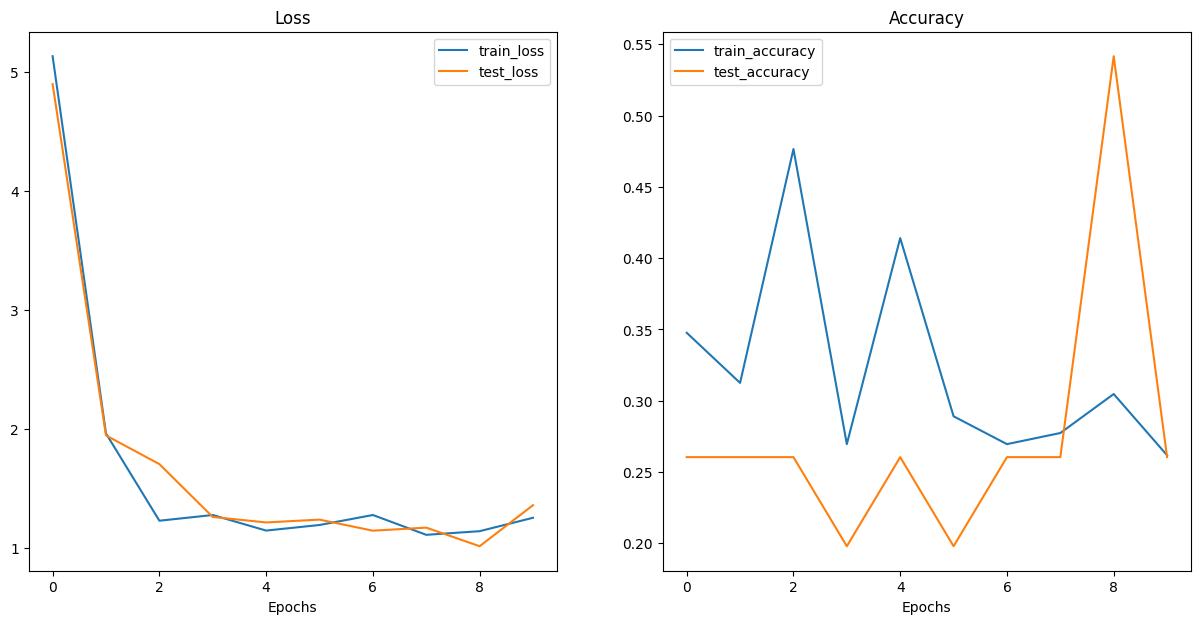

In [89]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [91]:
pretrained_vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
for param in pretrained_vit.parameters():
    param.requires_grad = False  # Freeze all parameters
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))
summary(
    model=pretrained_vit,
    input_size=(32, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [92]:
pretrained_vit_transforms = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [93]:
train_loader, test_loader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE
)

In [95]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_loader,
                                      test_dataloader=test_loader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [00:11<01:40, 11.16s/it]

Epoch: 1 | train_loss: 0.7222 | train_acc: 0.7734 | test_loss: 0.5134 | test_acc: 0.8267


 20%|██        | 2/10 [00:22<01:32, 11.53s/it]

Epoch: 2 | train_loss: 0.3236 | train_acc: 0.9453 | test_loss: 0.3306 | test_acc: 0.8674


 30%|███       | 3/10 [00:34<01:20, 11.45s/it]

Epoch: 3 | train_loss: 0.1996 | train_acc: 0.9570 | test_loss: 0.2720 | test_acc: 0.8977


 40%|████      | 4/10 [00:45<01:08, 11.43s/it]

Epoch: 4 | train_loss: 0.1531 | train_acc: 0.9688 | test_loss: 0.2459 | test_acc: 0.8977


 50%|█████     | 5/10 [00:58<00:58, 11.77s/it]

Epoch: 5 | train_loss: 0.1242 | train_acc: 0.9688 | test_loss: 0.2390 | test_acc: 0.8977


 60%|██████    | 6/10 [01:09<00:46, 11.65s/it]

Epoch: 6 | train_loss: 0.1252 | train_acc: 0.9766 | test_loss: 0.2285 | test_acc: 0.8977


 70%|███████   | 7/10 [01:20<00:34, 11.51s/it]

Epoch: 7 | train_loss: 0.0935 | train_acc: 0.9805 | test_loss: 0.2567 | test_acc: 0.8778


 80%|████████  | 8/10 [01:32<00:22, 11.47s/it]

Epoch: 8 | train_loss: 0.0799 | train_acc: 0.9844 | test_loss: 0.2471 | test_acc: 0.8778


 90%|█████████ | 9/10 [01:43<00:11, 11.46s/it]

Epoch: 9 | train_loss: 0.1035 | train_acc: 0.9844 | test_loss: 0.2238 | test_acc: 0.9081


100%|██████████| 10/10 [01:56<00:00, 11.66s/it]

Epoch: 10 | train_loss: 0.0642 | train_acc: 0.9883 | test_loss: 0.1957 | test_acc: 0.9280


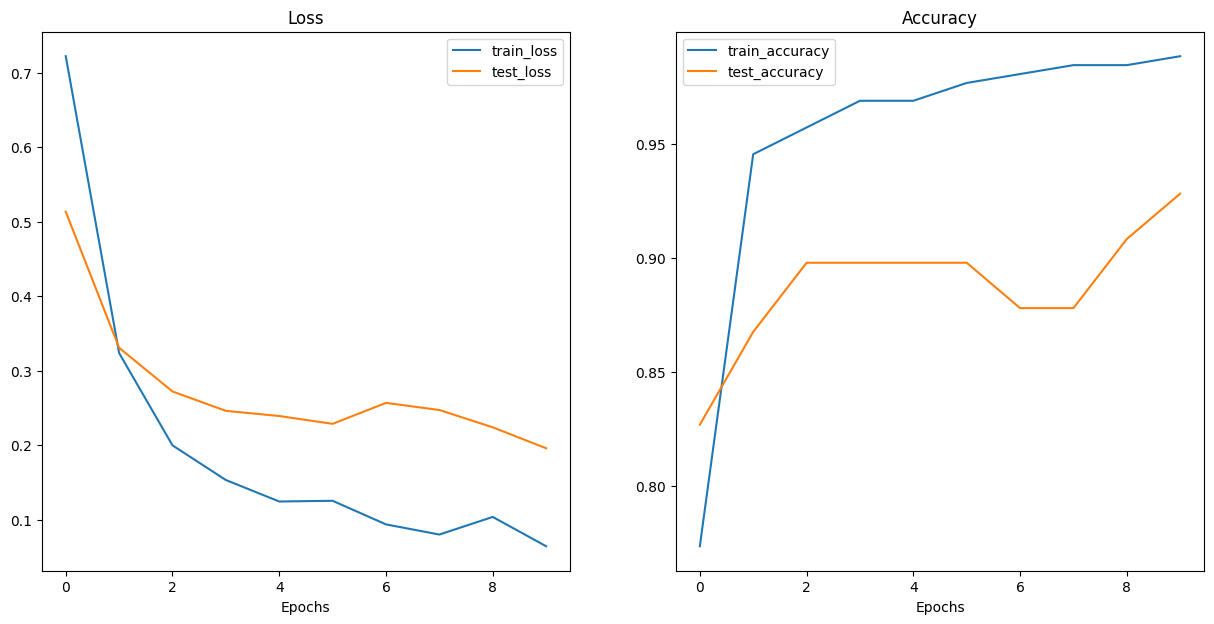

In [96]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [97]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


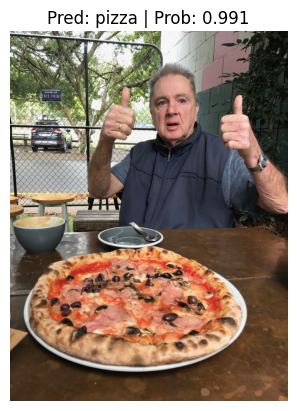

In [99]:
import requests
from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        print("Custom image not found, downloading...")
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)